Library

In [23]:
import yfinance as yf
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.models import load_model

Import Data

In [63]:
df = yf.download("AMZN", start = "2022-01-01", end = "2025-05-01")
print(date.today().strftime("%Y-%m-%d"))

data = df['Close'].values

print("Record:",len(data))
print(df.tail())

[*********************100%***********************]  1 of 1 completed

2025-05-03
Record: 834
Price            Close        High         Low        Open    Volume
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN
Date                                                                
2025-04-24  186.539993  186.740005  180.179993  180.919998  43763200
2025-04-25  188.990005  189.940002  185.490005  187.619995  36414300
2025-04-28  187.699997  190.220001  184.889999  190.110001  33224700
2025-04-29  187.389999  188.020004  183.679993  183.990005  41667300
2025-04-30  184.419998  185.050003  178.850006  182.169998  55176500


Plot Graph

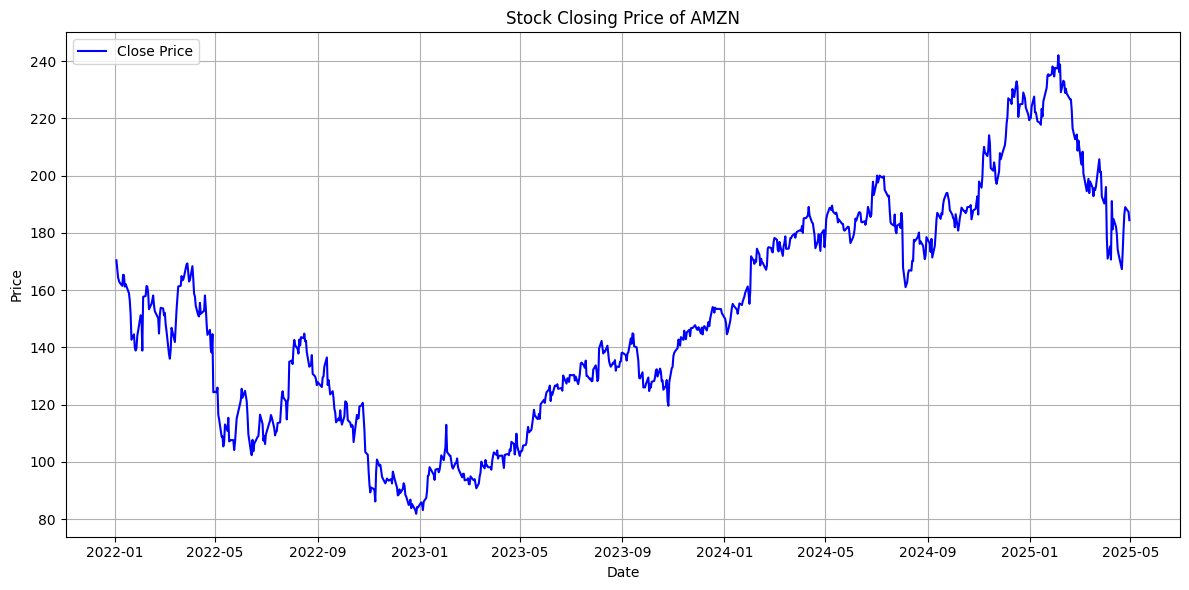

In [64]:
plt.figure(figsize = (12, 6))
plt.plot(df.index, data, label = 'Close Price', color = 'blue')
plt.title("Stock Closing Price of AMZN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Scale Data Into [0,1] and 2D

In [65]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

Split Data and Select Time Step

In [66]:
time_step = 60
train_size = int(len(scaled_data) * 0.8) 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Model LSTM

In [71]:
model = Sequential()
model.add(LSTM(units = 64, return_sequences = False, input_shape = (X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Model

In [72]:
history = model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_split = 0.2)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0368 - val_loss: 0.0058
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

Check Overfitting

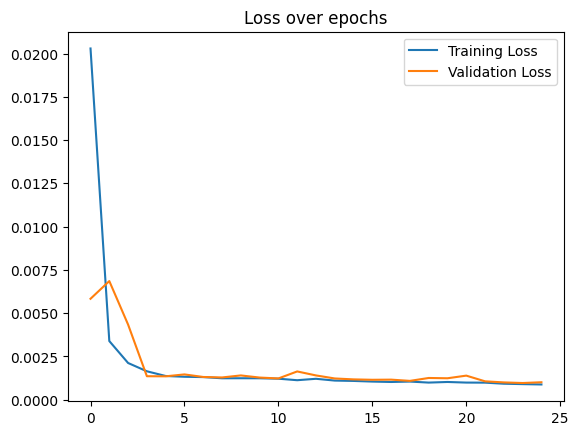

In [73]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [74]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train RMSE: 4.886454965926884
Test RMSE: 6.598156950903322


Evalute Model

In [75]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [76]:
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 43.53567514875382
Root Mean Squared Error (RMSE): 6.598156950903322
R² Score: 0.8866647988314087


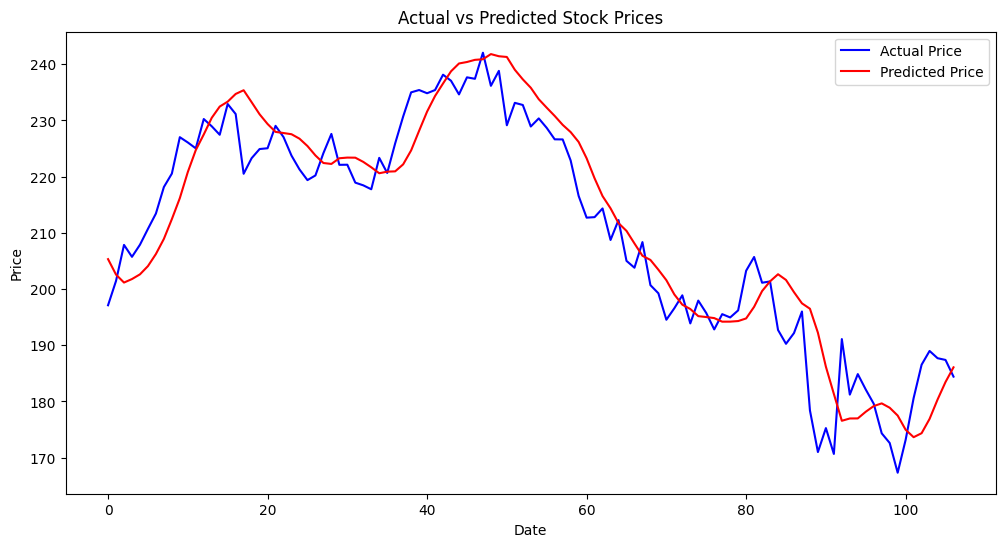

In [77]:
plt.figure(figsize = (12, 6))
plt.plot(y_test_actual, label = "Actual Price", color = 'blue')
plt.plot(predictions, label = "Predicted Price", color = 'red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Save Model

In [78]:
model.save("AMZN_model1.h5")

In [ ]:
model = load_model("AMZN_model1.h5")

Prediction

In [79]:
df = yf.download("AMZN", start = "2022-01-01", end = "2025-05-01")
data = df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [80]:
time_step = 60
dataf = yf.download("AMZN", period = "61d")
dataf = dataf[:-1]
last_60 = dataf['Close'].values[-time_step:]
last_60_scaled = scaler.transform(last_60.reshape(-1, 1))
X_input = last_60_scaled.reshape(1, time_step, 1)
print(len(last_60))
print(dataf.tail())

[*********************100%***********************]  1 of 1 completed

60
Price            Close        High         Low        Open    Volume
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN
Date                                                                
2025-04-25  188.990005  189.940002  185.490005  187.619995  36414300
2025-04-28  187.699997  190.220001  184.889999  190.110001  33224700
2025-04-29  187.389999  188.020004  183.679993  183.990005  41667300
2025-04-30  184.419998  185.050003  178.850006  182.169998  55176500
2025-05-01  190.199997  191.809998  187.500000  190.630005  73254700


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted next closing price: 189.37923


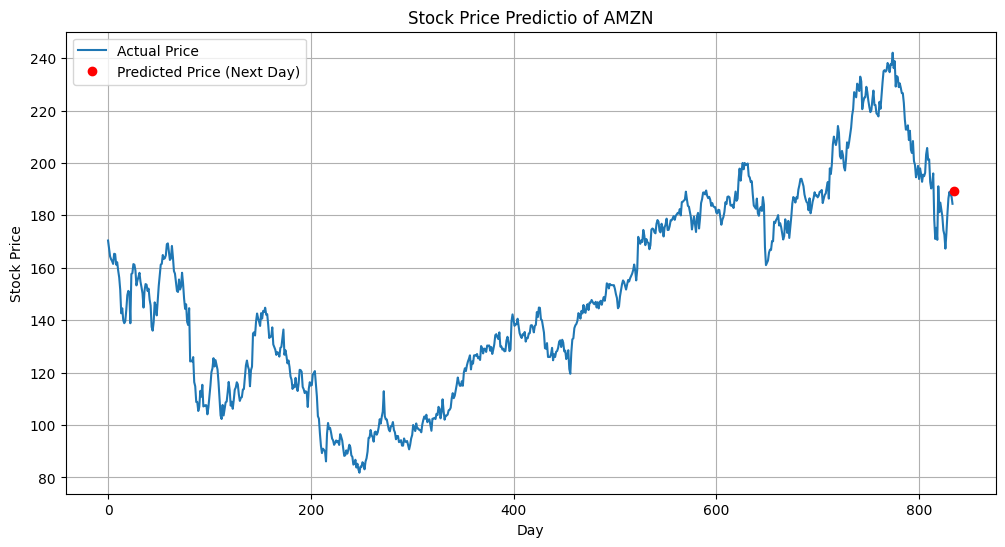

In [81]:
predicted_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next closing price:", predicted_price[0][0])

actual_prices = scaler.inverse_transform(scaled_data)

days = [i for i in range(len(actual_prices))]
days_pred = [len(actual_prices)]

plt.figure(figsize = (12, 6))
plt.plot(days, actual_prices, label = 'Actual Price')
plt.plot(days_pred, [predicted_price[0][0]], 'ro', label = 'Predicted Price (Next Day)')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Stock Price Predictio of AMZN")
plt.grid(True)
plt.show()